In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import plotly.express as px

from shutil import copyfile
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input,Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

In [2]:
#Define data path
CAT_DIR = './PetImages/Cat'
DOG_DIR = './PetImages/Dog'

try:
    os.makedirs(r'./tmp/cats-v-dogs')
    os.makedirs(r'./tmp/cats-v-dogs/training')
    os.makedirs(r'./tmp/cats-v-dogs/validation')
    os.makedirs(r'./tmp/cats-v-dogs/training/cats')
    os.makedirs(r'./tmp/cats-v-dogs/training/dogs')
    os.makedirs(r'./tmp/cats-v-dogs/validation/cats')
    os.makedirs(r'./tmp/cats-v-dogs/validation/dogs')
except OSError:
    print('Error failed to make directory')

Error failed to make directory


In [3]:
class_names = ['Cat', 'Dog'] 

n_dogs = len(os.listdir('PetImages/Dog'))
n_cats = len(os.listdir('PetImages/Cat'))
n_images = [n_cats, n_dogs]
px.pie(names=class_names, values=n_images)

In [4]:
def split_data(main_dir, training_dir, validation_dir, split_size):
    files = []
    for file in os.listdir(main_dir):
        if  os.path.getsize(os.path.join(main_dir, file)):
            files.append(file)

    shuffled_files = random.sample(files,  len(files))
    split = int(split_size * len(shuffled_files))

    train = shuffled_files[:split]
    validation = shuffled_files[split:]

    for element in train:
        copyfile(os.path.join(main_dir,  element), os.path.join(training_dir, element))

    for element in validation:
        copyfile(os.path.join(main_dir,  element), os.path.join(validation_dir, element))

In [5]:


split_data(CAT_DIR, 'tmp/cats-v-dogs/training/cats','tmp/cats-v-dogs/validation/cats', 0.9)
split_data(DOG_DIR, 'tmp/cats-v-dogs/training/dogs', 'tmp/cats-v-dogs/validation/dogs', 0.9)


In [6]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


valid_datagen = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory('tmp/cats-v-dogs/training',
                                                    batch_size = 64,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     


validation_generator =  valid_datagen.flow_from_directory( 'tmp/cats-v-dogs/validation',
                                                          batch_size  = 64,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 24752 images belonging to 2 classes.
Found 4753 images belonging to 2 classes.


In [7]:
def plot_data(generator, n_images):
    i = 1
    images, labels = generator.next()
    labels = labels.astype('int32')

    plt.figure(figsize=(14, 15))
    
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('on')
        i += 1
        if i == n_images:
            break
    
    plt.show()

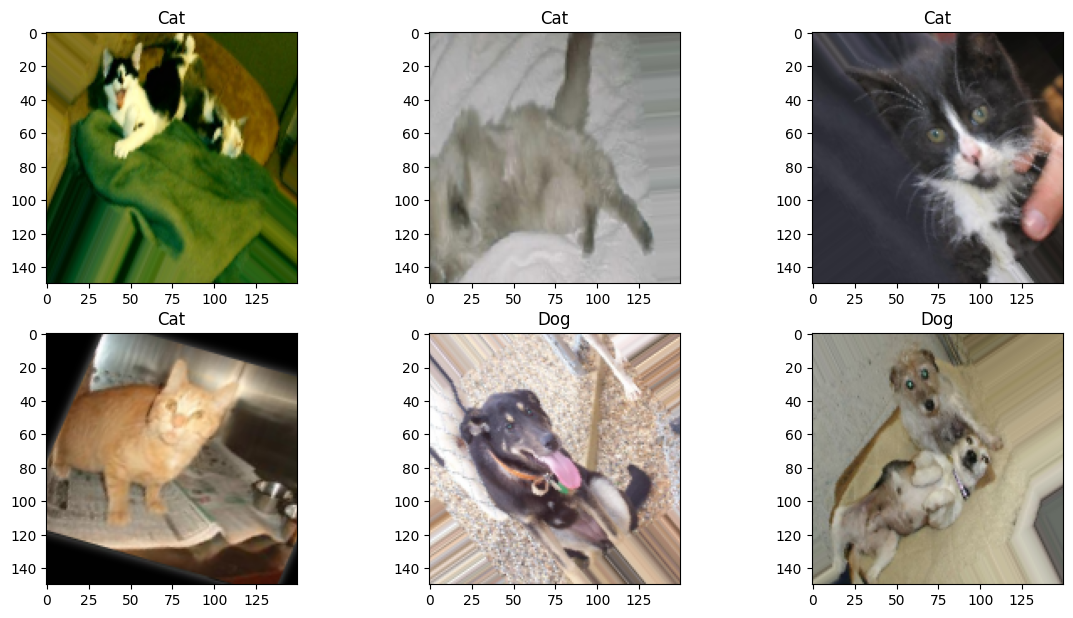

In [8]:
plot_data(train_generator, 7)

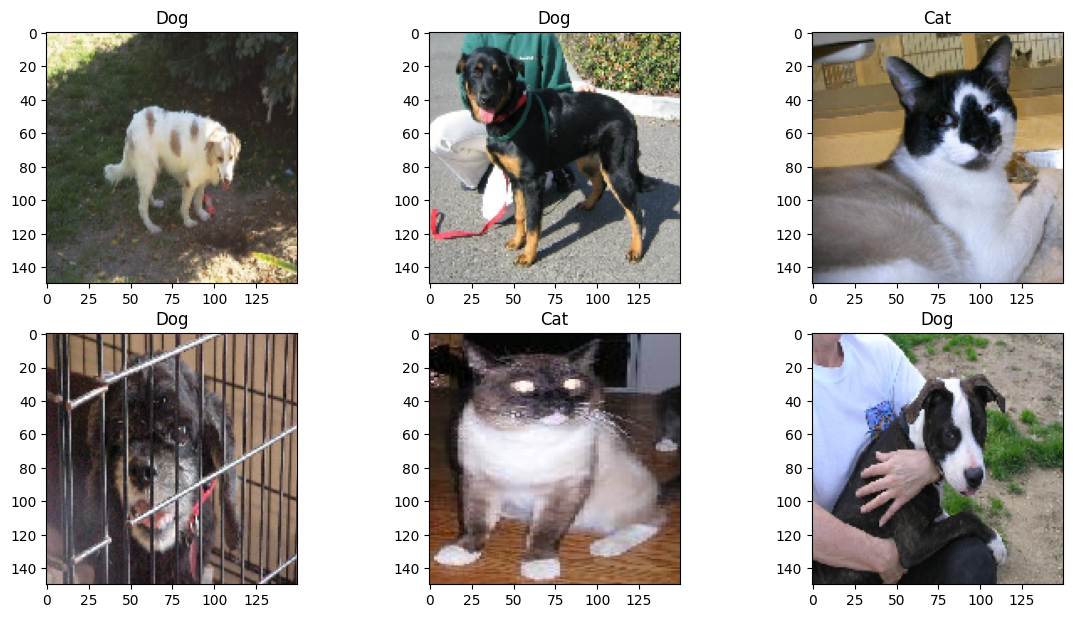

In [9]:

plot_data(validation_generator, 7)

In [10]:
#Load Model
inception = tf.keras.applications.InceptionV3(weights='imagenet',include_top=False,input_shape=(150,150,3))

for layer in inception.layers[:-10]:
    layer.trainable = False # Freeze weights of all layers till except the last 10
    
last_layer = inception.get_layer('mixed7')

print('last layer output shape: ', last_layer.output_shape)

layer_output = last_layer.output

87910968/87910968 [==============================] - 13s 0us/step
last layer output shape:  (None, 7, 7, 768)


In [11]:
x = Flatten()(layer_output)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inception.input, predictions)

# model.summary()

In [12]:
def scheduler(epoch, lr):
    
    if epoch < 20:
        return lr
    else:
        return lr * tf.math.exp(-0.2)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler) # set the callback to our scheduler function

In [13]:
# Set the training parameters
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

In [17]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 20,callbacks=[callback])

Epoch 1/20
 89/387 [=====>........................] - ETA: 7:55 - loss: 0.3732 - accuracy: 0.9041

c:\Users\merda\Documents\GitHub\python-ai\pr1\.venv\lib\site-packages\PIL\TiffImagePlugin.py:845: UserWarning:

Truncated File Read



387/387 [==============================] - 735s 2s/step - loss: 0.3331 - accuracy: 0.9147 - val_loss: 0.1801 - val_accuracy: 0.9642 - lr: 1.0000e-04
Epoch 2/20
387/387 [==============================] - 618s 2s/step - loss: 0.2789 - accuracy: 0.9276 - val_loss: 0.1815 - val_accuracy: 0.9640 - lr: 1.0000e-04
Epoch 3/20
 66/387 [====>.........................] - ETA: 7:34 - loss: 0.2498 - accuracy: 0.9309

KeyboardInterrupt: 